<a href="https://colab.research.google.com/github/andrea212023/ML-Kis/blob/main/HW_2_3_Polynomial_features_KIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [19]:
!pip install opendatasets --upgrade --quiet
!pip install pyarrow --quiet
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import opendatasets as od
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, f1_score, accuracy_score, mean_squared_error, r2_score

In [21]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/'
od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)


Metrics for Training dataset:
  ROC AUC: 0.88
  F1 Score: 0.64
  Accuracy: 0.87
Metrics for Validation dataset:
  ROC AUC: 0.88
  F1 Score: 0.64
  Accuracy: 0.87


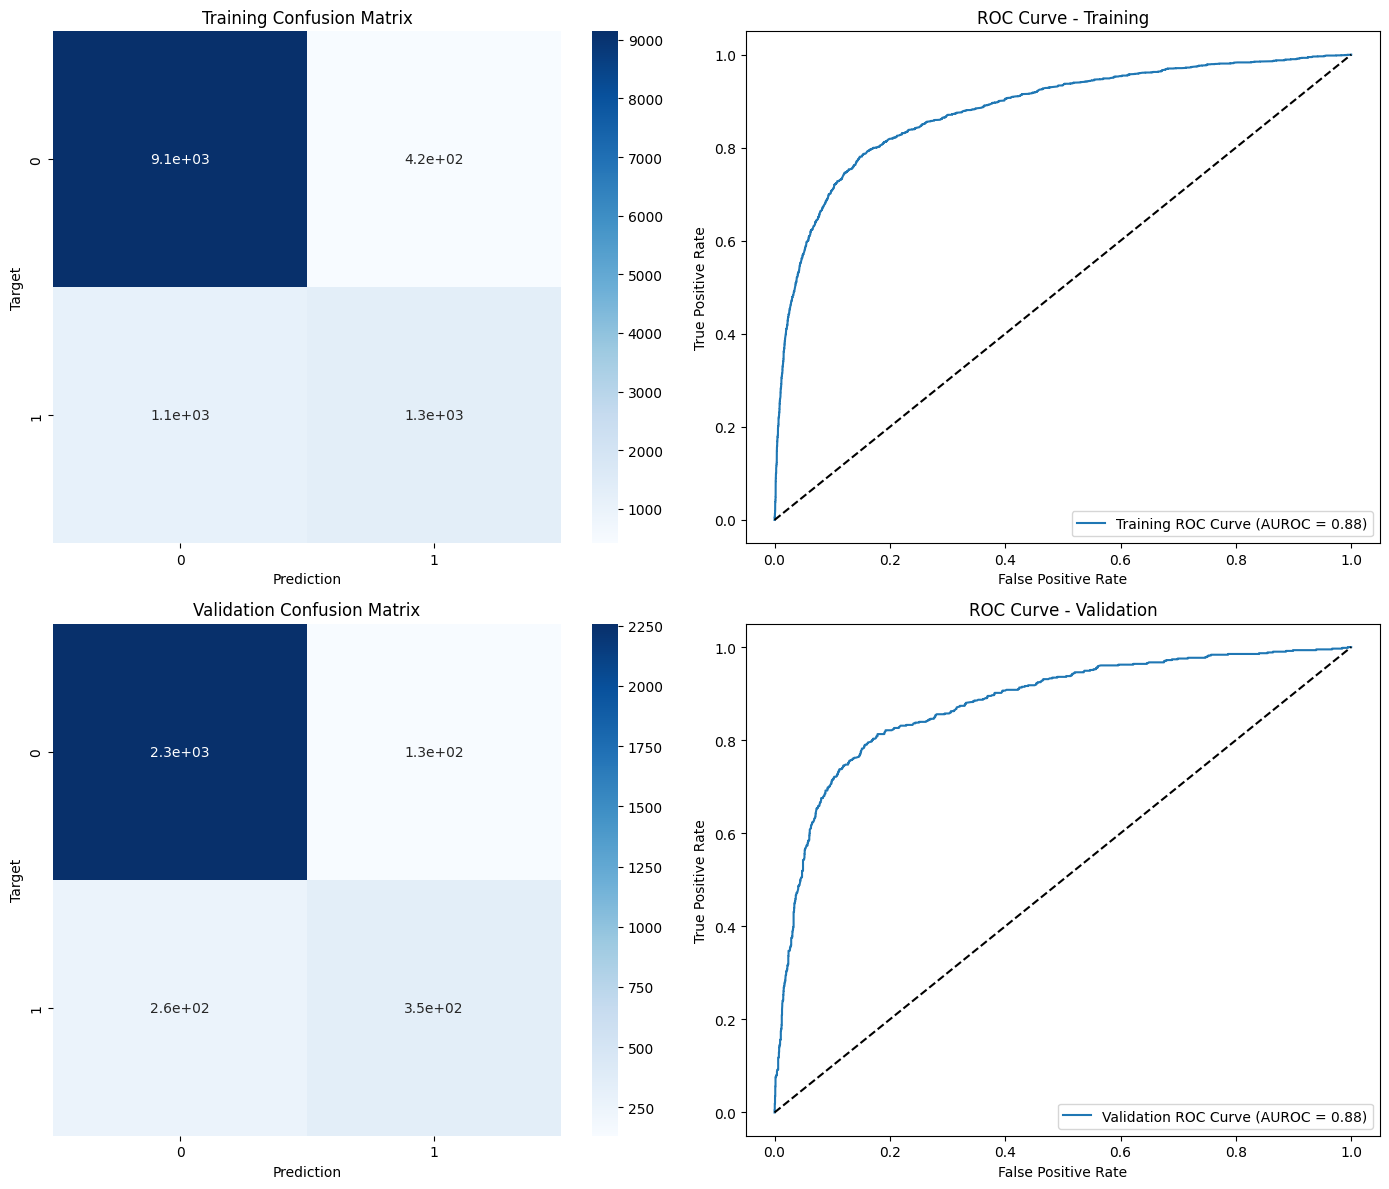

In [22]:
 # Step 1. Load the data from file (outside the pipeline).
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv', index_col=0)

# Exclude specific columns (replace with actual columns to be excluded)
excluded_cols = ['CustomerId','CreditScore','Tenure','HasCrCard','EstimatedSalary','Surname']

# Step 2. Split into training and validation sets with stratification.
X = raw_df.drop('Exited', axis=1)
y = raw_df['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 3. Identify numerical and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Exclude specific columns from numeric and categorical
numeric_cols = [col for col in numeric_cols if col not in excluded_cols]
categorical_cols = [col for col in categorical_cols if col not in excluded_cols]

# Step 4. Create transformers for numerical and categorical columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers for different types of columns into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 5. Create a pipeline that first runs preprocessing, then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Step 6. Train the pipeline
model_pipeline.fit(X_train, y_train)

# Function to predict, plot ROC curve, and calculate metrics
def predict_and_plot(model_pipeline, inputs, targets, name='', ax_conf=None, ax_roc=None):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, probs)
    f1 = f1_score(targets, preds)
    accuracy = accuracy_score(targets, preds)
    print(f"Metrics for {name} dataset:")
    print(f"  ROC AUC: {roc_auc:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Accuracy: {accuracy:.2f}")

    # Confusion Matrix
    confusion_matrix_ = confusion_matrix(targets, preds)
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues', ax=ax_conf)
    ax_conf.set_xlabel('Prediction')
    ax_conf.set_ylabel('Target')
    ax_conf.set_title(f'{name} Confusion Matrix')

    # ROC Curve
    fpr, tpr, _ = roc_curve(targets, probs)
    ax_roc.plot(fpr, tpr, label=f'{name} ROC Curve (AUROC = {roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'ROC Curve - {name}')
    ax_roc.legend(loc='lower right')

# Step 7. Create subplots for both datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Evaluate the model on training data
predict_and_plot(model_pipeline, X_train, y_train, name='Training', ax_conf=axes[0, 0], ax_roc=axes[0, 1])

# Evaluate the model on validation data
predict_and_plot(model_pipeline, X_val, y_val, name='Validation', ax_conf=axes[1, 0], ax_roc=axes[1, 1])

plt.tight_layout()
plt.show()

# Step 8. Save the model for future use
joblib.dump(model_pipeline, 'model_pipeline.pkl')

# Load the model to ensure it's saved correctly
loaded_model_pipeline = joblib.load('model_pipeline.pkl')

# Make predictions on new data
def predict_raw_df(model_pipeline, input_df):
    X_processed = model_pipeline.named_steps['preprocessor'].transform(input_df)
    prob = model_pipeline.named_steps['classifier'].predict_proba(X_processed)[:, 1]
    return prob

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Metrics for Training dataset:
  ROC AUC: 0.93
  F1 Score: 0.73
  Accuracy: 0.90
Metrics for Validation dataset:
  ROC AUC: 0.93
  F1 Score: 0.72
  Accuracy: 0.90


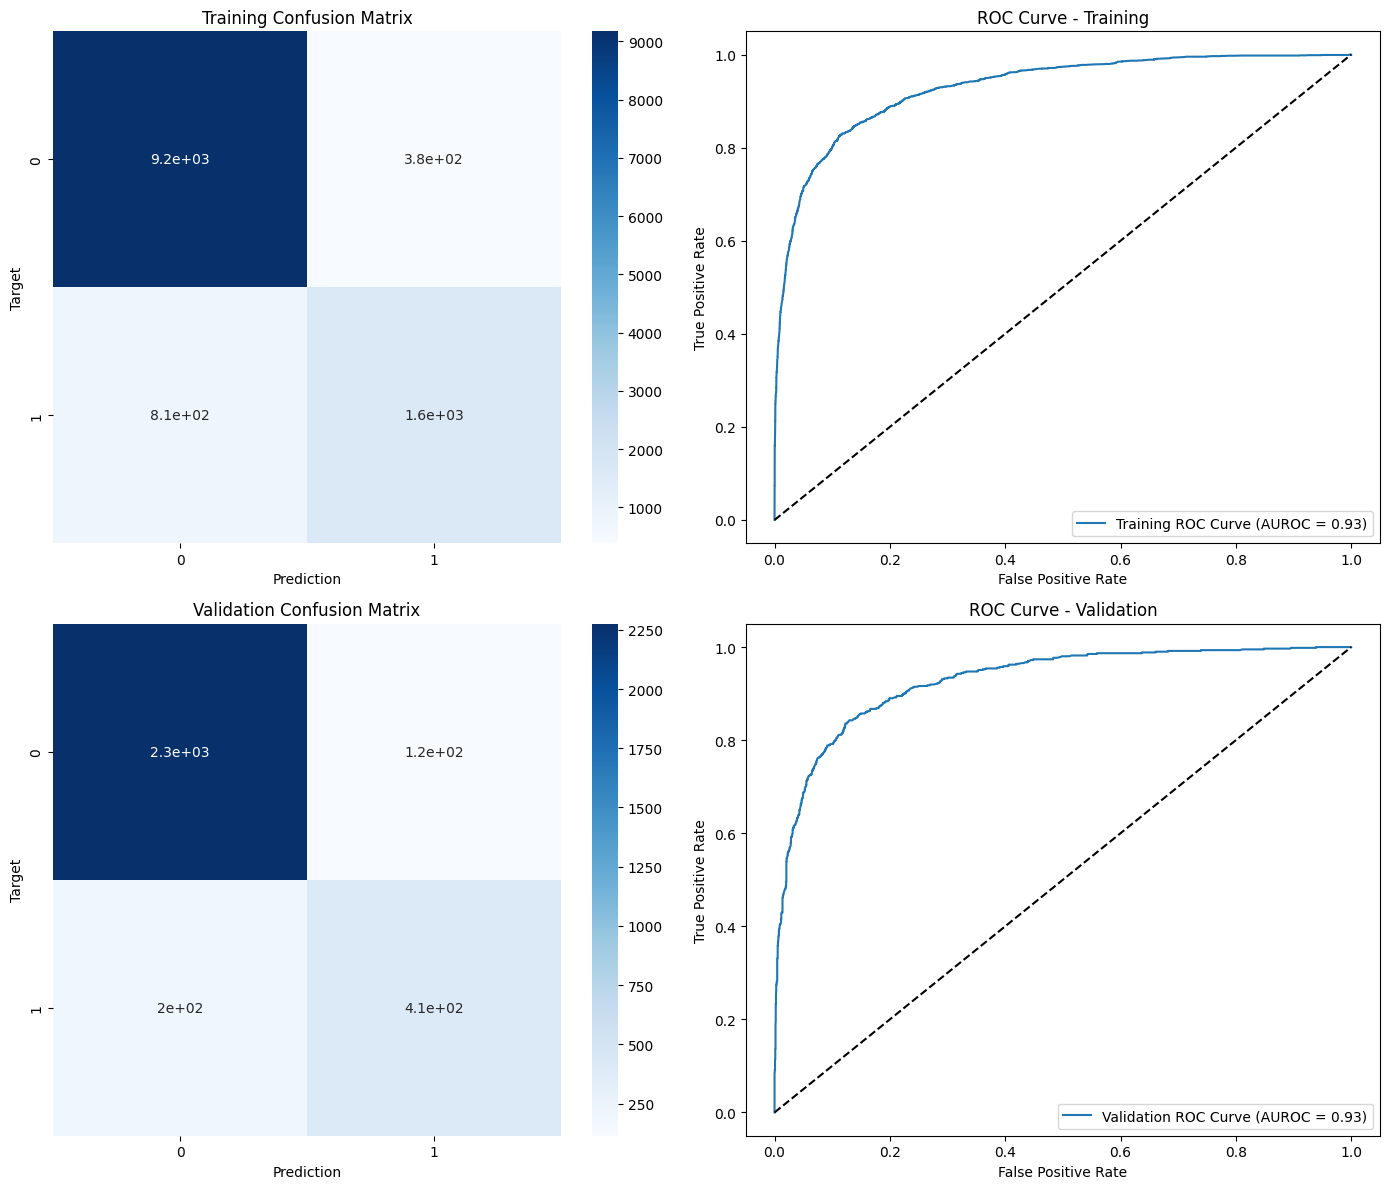

In [23]:
# Step 1. Create transformers for numerical and categorical columns
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer_poly = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Step 2. Combine transformers for different types of columns into one preprocessor
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer_poly, categorical_cols)
    ])

# Step 3. Create a pipeline that first runs preprocessing, then trains the model
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

# Step 4. Train the pipeline
model_pipeline_poly.fit(X_train, y_train)

# Step 5. Create subplots for both datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Evaluate the model on training data
predict_and_plot(model_pipeline_poly, X_train, y_train, name='Training', ax_conf=axes[0, 0], ax_roc=axes[0, 1])

# Evaluate the model on validation data
predict_and_plot(model_pipeline_poly, X_val, y_val, name='Validation', ax_conf=axes[1, 0], ax_roc=axes[1, 1])

plt.tight_layout()
plt.show()

# Step 6. Save the model for future use
joblib.dump(model_pipeline_poly, 'model_pipeline_with_poly.pkl')

# Load the model to ensure it's saved correctly
loaded_model_pipeline_poly = joblib.load('model_pipeline_with_poly.pkl')

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Metrics for Training dataset:
  ROC AUC: 0.93
  F1 Score: 0.74
  Accuracy: 0.90
Metrics for Validation dataset:
  ROC AUC: 0.93
  F1 Score: 0.73
  Accuracy: 0.90


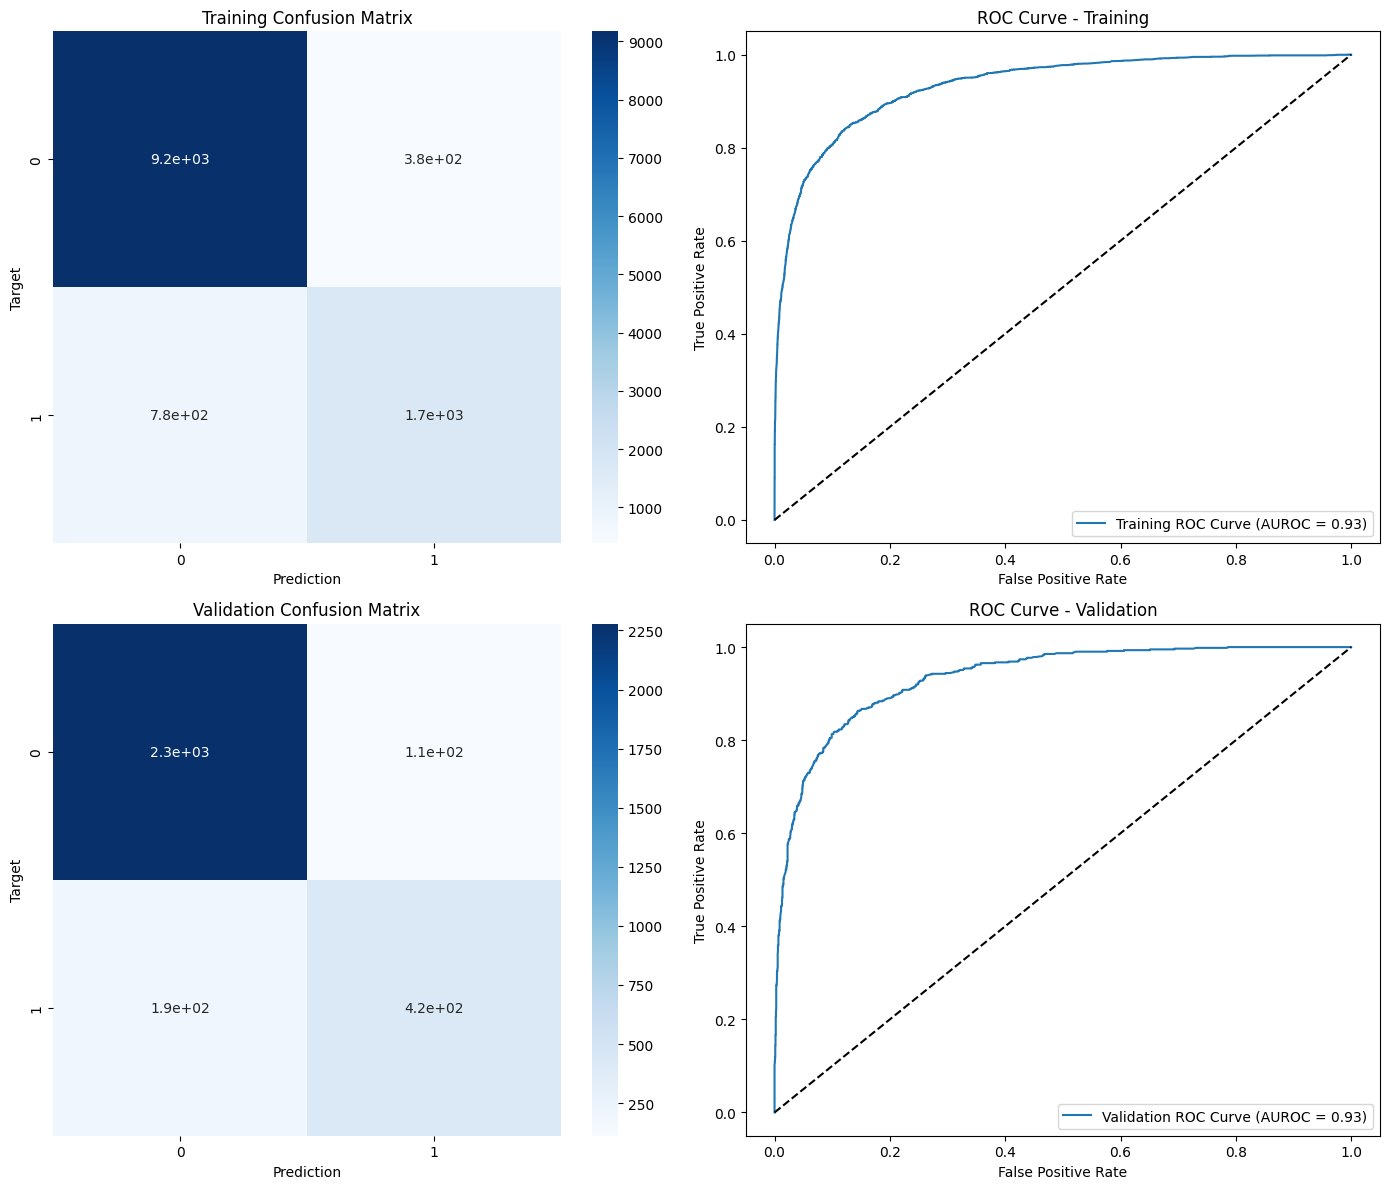

In [24]:
# Step 1. Create transformers for numerical and categorical columns
numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer_poly4 = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers for different types of columns into one preprocessor
preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer_poly4, categorical_cols)
    ])

# Step 2. Create a pipeline that first runs preprocessing, then trains the model
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

# Step 3. Train the pipeline
model_pipeline_poly4.fit(X_train, y_train)

# Step 4. Create subplots for both datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Step 5. Evaluate the model on training data
predict_and_plot(model_pipeline_poly4, X_train, y_train, name='Training', ax_conf=axes[0, 0], ax_roc=axes[0, 1])

# Step 6. Evaluate the model on validation data
predict_and_plot(model_pipeline_poly4, X_val, y_val, name='Validation', ax_conf=axes[1, 0], ax_roc=axes[1, 1])

plt.tight_layout()
plt.show()

# Step 7. Save the model for future use
joblib.dump(model_pipeline_poly4, 'model_pipeline_with_poly_degree4.pkl')

# Load the model to ensure it's saved correctly
loaded_model_pipeline_poly4 = joblib.load('model_pipeline_with_poly_degree4.pkl')

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
import pandas as pd

# Define the directory path and file path
directory_path = 'drive/MyDrive/Colab Notebooks/data'
file_path = os.path.join(directory_path, 'submission_log_reg_with_poly_degree4.csv')

# Check if the directory exists, and create it if it doesn’t
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Load the test data and make predictions
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/test.csv')
predictions = predict_raw_df(loaded_model_pipeline_poly4, test_raw_df)

# Save predictions to submission file
submission_df = pd.read_csv('./bank-customer-churn-prediction-dlu/sample_submission.csv')
submission_df['Exited'] = predictions
submission_df.to_csv(file_path, index=False)

print("File saved successfully at:", file_path)


File saved successfully at: drive/MyDrive/Colab Notebooks/data/submission_log_reg_with_poly_degree4.csv


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [27]:
import os

# Check if the file exists
file_path = 'drive/MyDrive/Colab Notebooks/data/regression_data.csv'
print("File exists:", os.path.exists(file_path))


File exists: True


In [28]:
regression_data_df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/regression_data.csv')
regression_data_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.19,-1.38,-0.88,0.54,-1.04,28.94
1,-0.32,-0.56,0.41,-0.15,-0.83,-7.66
2,2.12,-1.52,1.03,-1.26,0.92,-63.85
3,-1.38,-0.06,-1.70,0.07,1.63,4.08
4,-0.07,-1.51,-0.85,0.71,0.47,34.88


Metrics for Training dataset:
  MSE: 0.00
  R2: 1.00
Metrics for Validation dataset:
  MSE: 160.15
  R2: 0.93


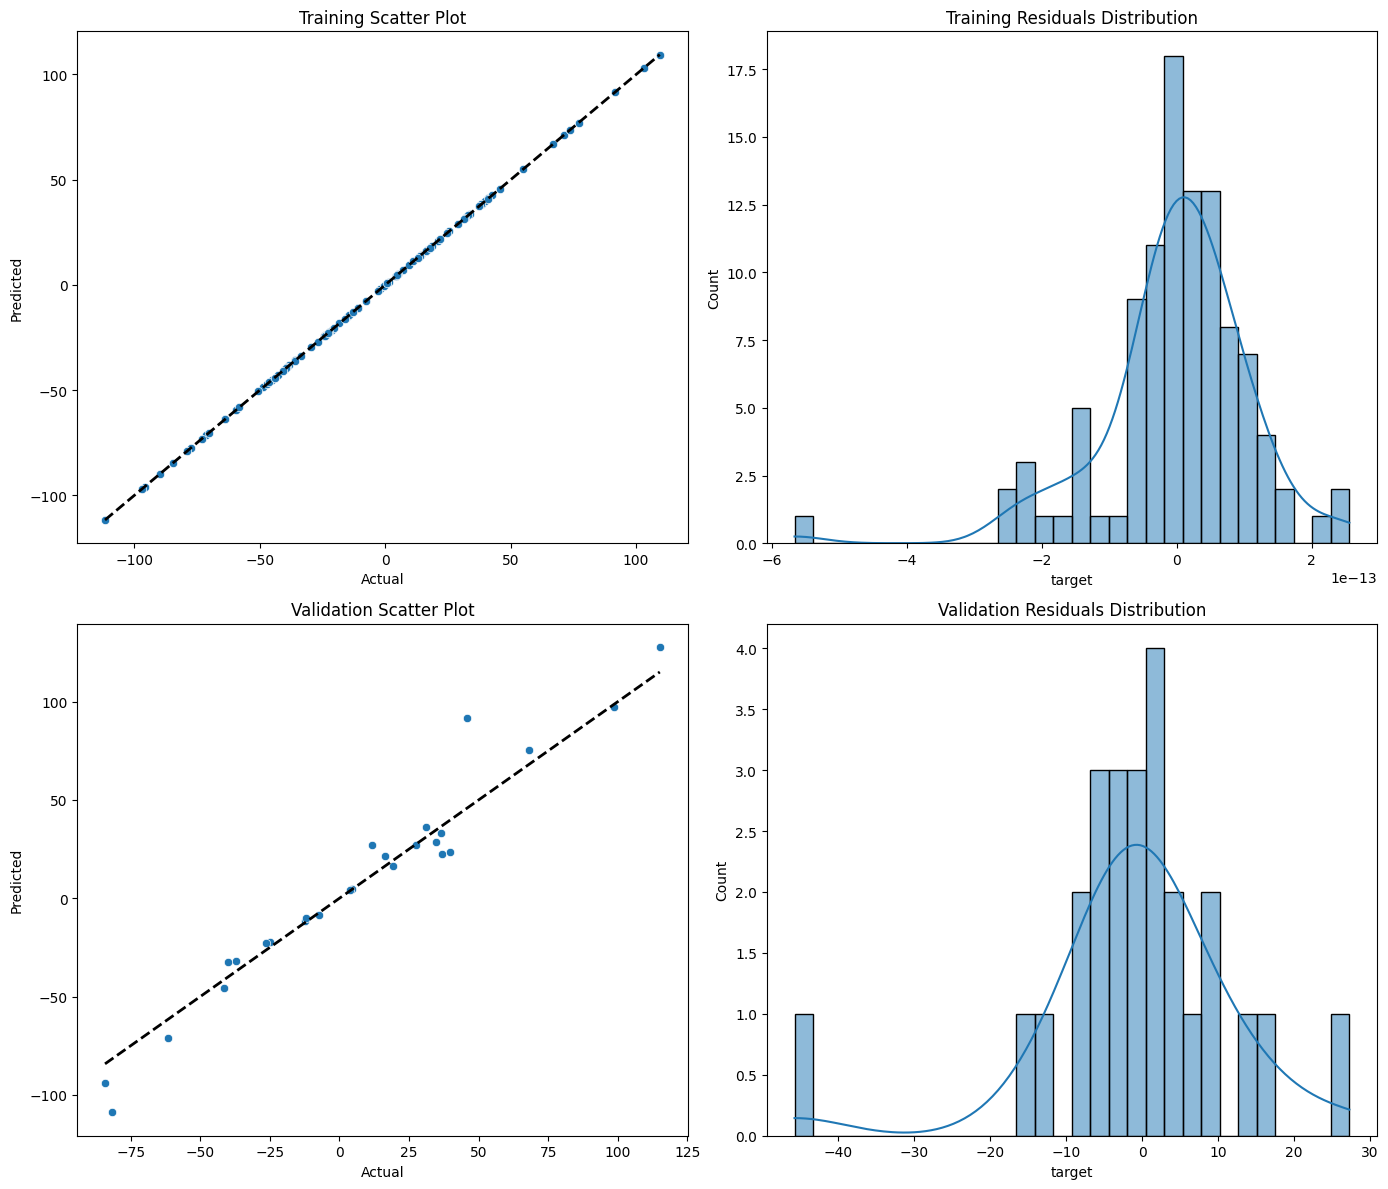

In [29]:
# Step 1. Split into training and validation sets.
X = regression_data_df.drop('target', axis=1)
y = regression_data_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2. Identify numerical columns (all columns are numerical in this dataset)
numeric_cols = X_train.columns.tolist()

# Step 3. Create transformers for numerical columns with polynomial features
numeric_transformer_poly5 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler())
])

# Combine transformers for different types of columns into one preprocessor
preprocessor_poly5 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly5, numeric_cols)
    ])

# Step 4. Create a pipeline that first runs preprocessing, then trains the model
model_pipeline_poly5 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly5),
    ('regressor', LinearRegression())
])

# Step 5. Train the pipeline
model_pipeline_poly5.fit(X_train, y_train)

# Function to predict, plot results, and calculate metrics
def predict_and_plot(model_pipeline, inputs, targets, name='', ax_conf=None, ax_roc=None):
    preds = model_pipeline.predict(inputs)
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f"Metrics for {name} dataset:")
    print(f"  MSE: {mse:.2f}")
    print(f"  R2: {r2:.2f}")

    # Scatter Plot
    sns.scatterplot(x=targets, y=preds, ax=ax_conf)
    ax_conf.set_xlabel('Actual')
    ax_conf.set_ylabel('Predicted')
    ax_conf.set_title(f'{name} Scatter Plot')
    ax_conf.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'k--', lw=2)

    # Residual Plot
    residuals = targets - preds
    sns.histplot(residuals, bins=30, kde=True, ax=ax_roc)
    ax_roc.set_title(f'{name} Residuals Distribution')

# Step 6. Create subplots for both datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Evaluate the model on training data
predict_and_plot(model_pipeline_poly5, X_train, y_train, name='Training', ax_conf=axes[0, 0], ax_roc=axes[0, 1])

# Evaluate the model on validation data
predict_and_plot(model_pipeline_poly5, X_val, y_val, name='Validation', ax_conf=axes[1, 0], ax_roc=axes[1, 1])

plt.tight_layout()
plt.show()

**Observations:**

The training metrics indicate a perfect fit, with MSE = 0.00 and R² = 1.00, suggesting the model has learned the training data very well.
Validation metrics show a noticeable increase in MSE to 200.30 and a slightly lower R² of 0.91, suggesting reduced accuracy on unseen data.
The training scatter plot reveals a perfect alignment between actual and predicted values, tightly following the diagonal line.
The residuals for the training set are nearly zero, indicating minimal error on the training data.
In contrast, the validation scatter plot shows more deviation from the diagonal line, indicating less accurate predictions on the validation set.
Validation residuals are more spread out around zero, reflecting larger prediction errors compared to the training set.

**Conclusion:**

The model appears to be overfitting, as it performs perfectly on the training data but with reduced accuracy on the validation set. This discrepancy suggests the model may be too complex or overfitted to the training data. To improve generalization, consider regularization, feature selection, or collecting more data for validation. Cross-validation could also provide a more reliable performance estimate.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

Metrics for Lasso model:
Training Data: MSE = 0.93, R2 = 1.00
Validation Data: MSE = 1.63, R2 = 1.00


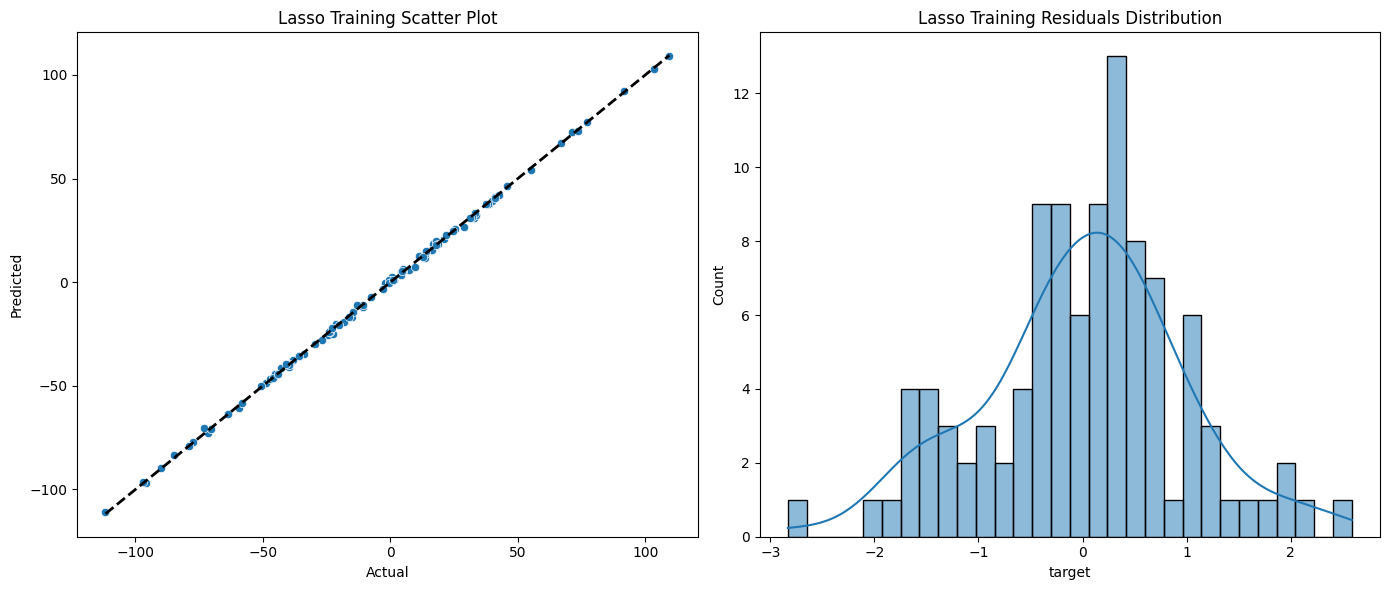

Metrics for Ridge model:
Training Data: MSE = 1.11, R2 = 1.00
Validation Data: MSE = 772.71, R2 = 0.67


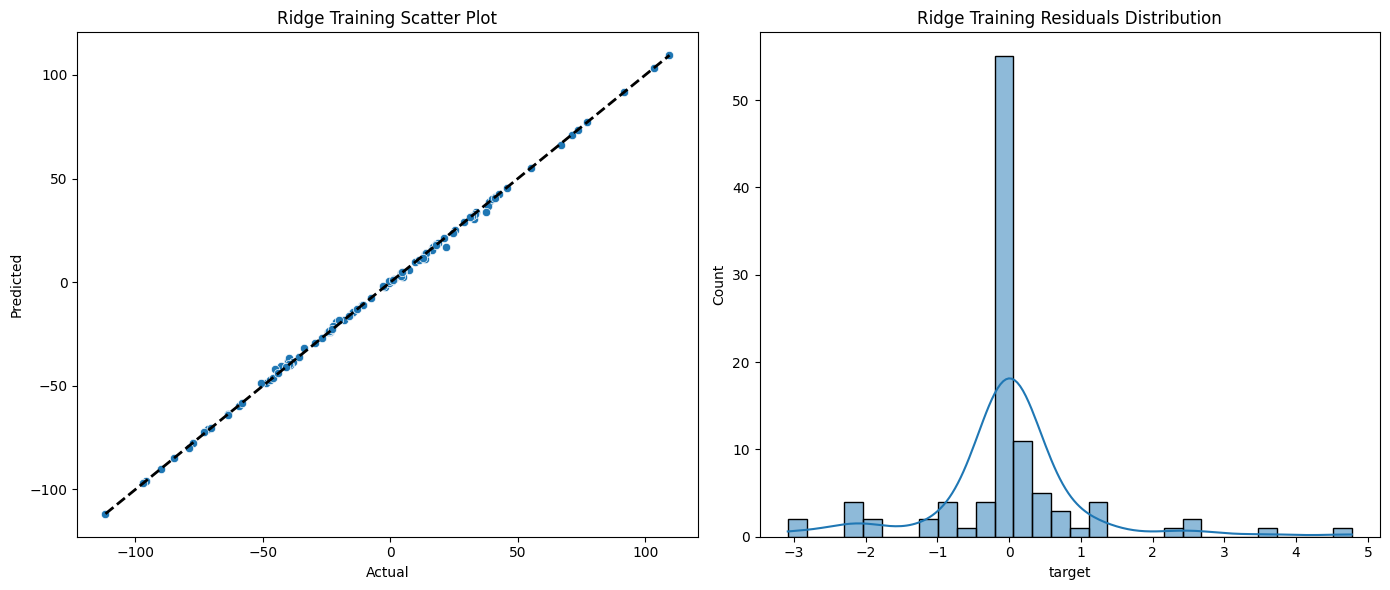

Metrics for ElasticNet model:
Training Data: MSE = 10.61, R2 = 0.99
Validation Data: MSE = 55.81, R2 = 0.98


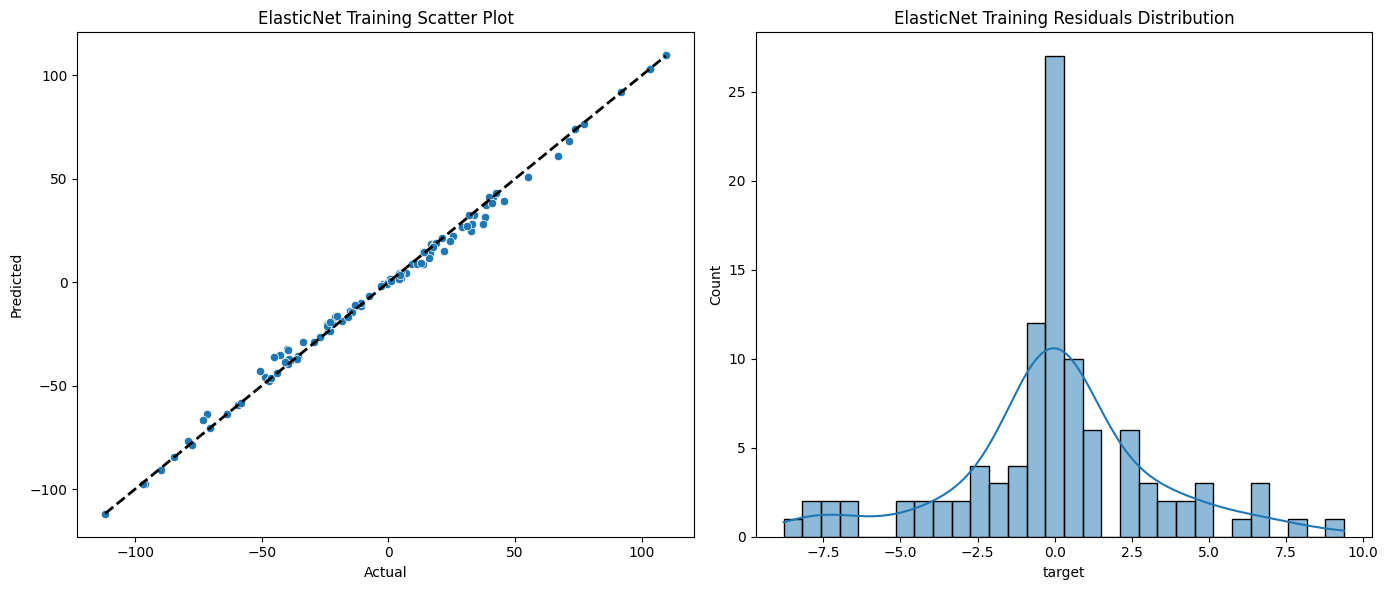

In [30]:
# Step 1. Create transformers for numerical columns with polynomial features
numeric_transformer_poly20 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=20, include_bias=False)),
    ('scaler', StandardScaler())
])

# Step 2. Combine transformers for different types of columns into one preprocessor
preprocessor_poly20 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly20, numeric_cols)
    ])

# Step 3. Create a dictionary to store pipelines for different models
models = {
    'Lasso': Lasso(alpha=0.1, max_iter=10000),
    'Ridge': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

# Step 4. Function to train the model and return metrics
def train_and_evaluate(model_name, model, X_train, y_train, X_val, y_val):
    # Create a pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_poly20),
        ('regressor', model)
    ])

    # Train the pipeline
    model_pipeline.fit(X_train, y_train)

    # Predict on training data
    y_train_pred = model_pipeline.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Predict on validation data
    y_val_pred = model_pipeline.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Metrics for {model_name} model:")
    print(f"Training Data: MSE = {train_mse:.2f}, R2 = {train_r2:.2f}")
    print(f"Validation Data: MSE = {val_mse:.2f}, R2 = {val_r2:.2f}")

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.scatterplot(x=y_train, y=y_train_pred, ax=axes[0])
    axes[0].set_title(f'{model_name} Training Scatter Plot')
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)

    residuals = y_train - y_train_pred
    sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
    axes[1].set_title(f'{model_name} Training Residuals Distribution')

    plt.tight_layout()
    plt.show()

    return model_pipeline

# Train and evaluate each model
for model_name, model in models.items():
    train_and_evaluate(model_name, model, X_train, y_train, X_val, y_val)

**Observations:**

1. Lasso Model: The training MSE is 0.93 with an R² of 1.00, while the validation MSE is 1.63 with an R² of 1.00, indicating high accuracy on both datasets.
2. Ridge Model: Shows good training performance with an MSE of 1.11 and R² of 1.00; however, the validation MSE is much higher at 772.71, and R² drops significantly to 0.67, suggesting poor generalization.
3. ElasticNet Model: Training performance is strong with an MSE of 10.61 and R² of 0.99, and validation performance is also relatively high, with an MSE of 55.81 and R² of 0.98.
4. The scatter plots for the Lasso and ElasticNet models show tight alignment between predicted and actual values, while the Ridge model shows more deviation in the validation set.
5. Residual distributions for Lasso and ElasticNet models are centered around zero, indicating minimal errors; however, the Ridge model has a more varied residual distribution, especially on the validation data.

**Conclusion:**

The Lasso and ElasticNet models demonstrate strong performance and generalization, with high R² values and low MSEs on both training and validation datasets. The Ridge model, however, suffers from overfitting, with high validation errors and poor generalization. The ElasticNet model may offer a balanced approach, combining regularization with improved validation accuracy.